In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy.stats import ttest_1samp
from itertools import product

from ancestrator import *

def all_gal_panels():
    aims_count = lambda p: len(Panel(p).snps)
    labels = [l for l in Panel.available_panels()
              if re.match('(GAL_C|GAL_A)', l)]
    panel_labels = sorted(labels, key=aims_count, reverse=True)
    return panel_labels

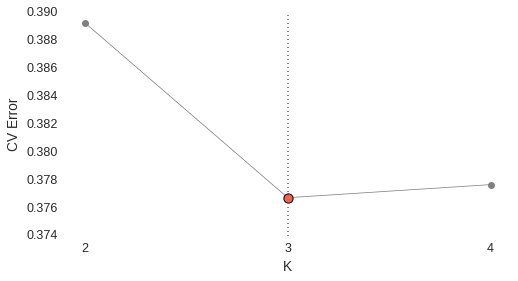

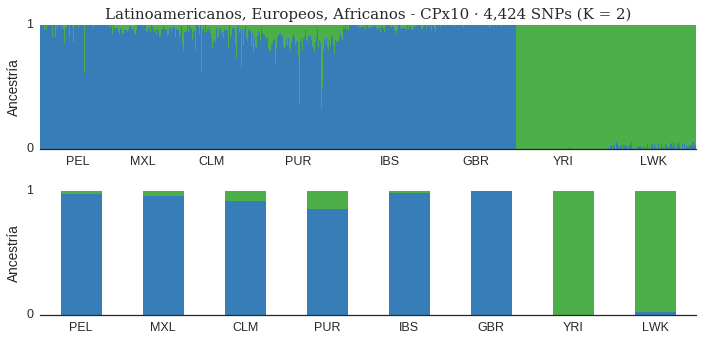

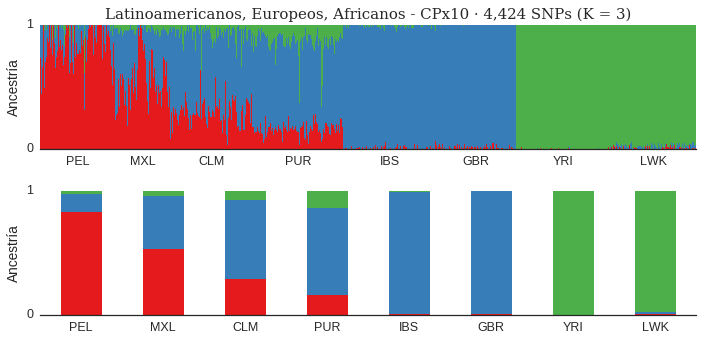

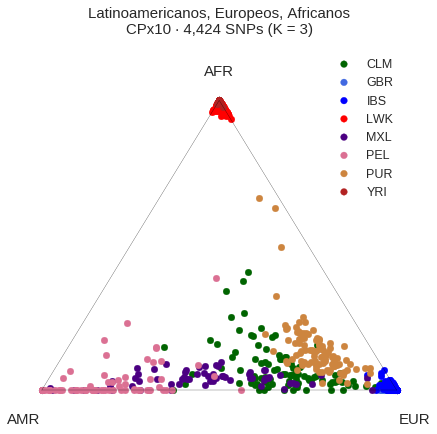

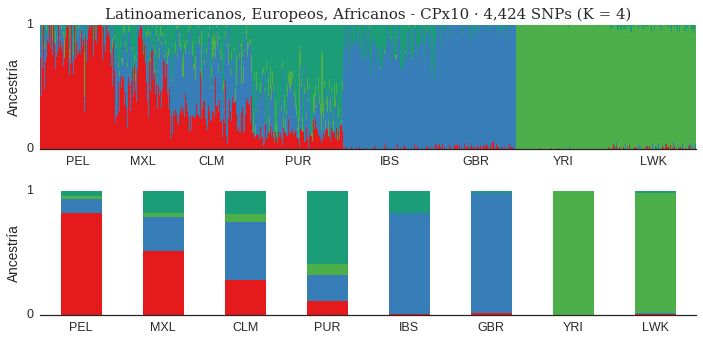

In [6]:
from itertools import product

sns.set_context('notebook',font_scale=1.25)
sns.set_style('white')

source_labels = ['1000Genomes']
samplegroup_labels = ['LEA']
panel_labels = [
 'GAL_Affy_SubPanel_100',
]
Ks = [3]

combo = product(source_labels, panel_labels, samplegroup_labels)

for source_label, panel_label, samplegroup_label in combo:
    dataset = Dataset(source_label, samplegroup_label, panel_label)
    admixture = dataset.admixture(Ks=Ks, cores=4)
    
    admixture.plot_cv_errors()
    
    for K in Ks:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
        admixture.plot(ax=ax1, K=K)
        admixture.plot(ax=ax2, K=K, population_means=True)
        ax2.set_title('')

        plt.tight_layout()
        plt.show()
        
        if K == 3:
            admixture.plot_triangle()


# Compare admixture ratios for GAl_Completo vs subpanels

paired t-test sobre las diferencias entre el estimado de ancestrías de cada panel y el estimado 'base' de `GAL_Completo`. La $H_{0}$ es que la media de las diferencias es 0, de modo que las diferencias observadas son atribuibles al azar. Por ende, el panel testeado no sobre/subestima ninguna ancestría en particular. La hipótesis alternativa es que la media de las diferencias es mayor o menor a 0, de modo que el panel sobre o subestima alguna de las ancestrías.

Un p-value < 0.05 establece que la diferencia es significativa, no atribuible al azar: la media no es 0. Es la probabilidad de obtener el resultado observado, por azar, a pesar de que la H0 sea verdadera.

Student's $t$ statistic: $t_{s} = \frac{\bar{x} - \mu_{0}}{s/\sqrt{n}}$

In [66]:
from collections import OrderedDict

samplegroup_label = 'LEA'
diff = OrderedDict()
K = 3

ref_dataset = Dataset('1000Genomes', samplegroup_label, 'GAL_Completo')
ref_admix = ref_dataset.admixture(Ks=K, overwrite=True)

ttest_results = pd.DataFrame({'panel': [], 'ancestry': [], 'p_value': []})
ttest_results = ttest_results.set_index(['panel', 'ancestry'])['p_value']

for panel_label in panel_labels:
    dataset = Dataset('1000Genomes', samplegroup_label, panel_label)
    admix = dataset.admixture(Ks=K, overwrite=True)
    difference = ref_admix.result[K] - admix.result[K]
    diff[dataset.full_label] = difference

    for ancestry in difference.columns:
        ttest = ttest_1samp(difference[ancestry], 0)
        ttest_results.loc[(panel_label, ancestry)] = ttest.pvalue

summed_diffs = pd.DataFrame({})  # <-
mean_diffs = pd.DataFrame({})  # <-
std_diffs = pd.DataFrame({})

for panel, diffs in diff.items():
    summed = diffs.sum()
    summed.name = panel
    summed_diffs = summed_diffs.append(summed)
    
    mean = diffs.mean()
    mean.name = panel
    mean_diffs = mean_diffs.append(mean)
    
    std = diffs.std()
    std.name = panel
    std_diffs = std_diffs.append(std)
        
ttest_results

panel                  ancestry
GAL_Affy               AMR         9.237398e-17
                       EUR         2.959477e-15
                       AFR         6.533826e-01
GAL_Affy_SubPanel_155  AMR         2.201210e-14
                       EUR         5.024693e-15
                       AFR         5.337672e-01
GAL_Affy_SubPanel_150  AMR         8.623269e-14
                       EUR         6.135120e-15
                       AFR         4.533213e-01
GAL_Affy_SubPanel_145  AMR         3.698262e-11
                       EUR         2.830083e-12
                       AFR         4.979871e-01
GAL_Affy_SubPanel_140  AMR         1.203020e-11
                       EUR         1.822281e-14
                       AFR         1.697986e-01
GAL_Affy_SubPanel_135  AMR         5.001742e-11
                       EUR         4.823984e-13
                       AFR         2.343837e-01
GAL_Affy_SubPanel_130  AMR         1.782639e-11
                       EUR         5.412303e-14
        

# Power analysis for each panel

In [56]:
from scipy.stats import norm, zscore

def sample_power_difftest(d, s, power=0.9, sig=0.05):
    z = norm.isf([sig/2])
    zp = -1 * norm.isf([power])
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

for dataset_label, differences in diff.items():
    print(dataset_label)
    for ancestry, std in differences.std().iteritems():
        print(ancestry, sample_power_difftest(0.05, std))
    print()

1000Genomes.LEA.GAL_Affy
AMR 127
EUR 129
AFR 91

1000Genomes.LEA.GAL_Affy_SubPanel_155
AMR 135
EUR 141
AFR 117

1000Genomes.LEA.GAL_Affy_SubPanel_150
AMR 139
EUR 144
AFR 121

1000Genomes.LEA.GAL_Affy_SubPanel_145
AMR 140
EUR 144
AFR 123

1000Genomes.LEA.GAL_Affy_SubPanel_140
AMR 144
EUR 149
AFR 128

1000Genomes.LEA.GAL_Affy_SubPanel_135
AMR 145
EUR 153
AFR 133

1000Genomes.LEA.GAL_Affy_SubPanel_130
AMR 147
EUR 154
AFR 134

1000Genomes.LEA.GAL_Affy_SubPanel_125
AMR 147
EUR 158
AFR 137

1000Genomes.LEA.GAL_Affy_SubPanel_120
AMR 151
EUR 162
AFR 142

1000Genomes.LEA.GAL_Affy_SubPanel_115
AMR 157
EUR 167
AFR 143

1000Genomes.LEA.GAL_Affy_SubPanel_110
AMR 161
EUR 172
AFR 145

1000Genomes.LEA.GAL_Affy_SubPanel_105
AMR 163
EUR 173
AFR 148

1000Genomes.LEA.GAL_Affy_SubPanel_100
AMR 168
EUR 181
AFR 155

1000Genomes.LEA.GAL_Affy_SubPanel_95
AMR 173
EUR 185
AFR 156

1000Genomes.LEA.GAL_Affy_SubPanel_90
AMR 181
EUR 193
AFR 160

1000Genomes.LEA.GAL_Affy_SubPanel_85
AMR 183
EUR 198
AFR 163

1000Genom

## Tidy dataframe for the differences of ancestry by sample/panel

In [35]:
tidy_diff = pd.DataFrame({})
aims_count = lambda label: len(Panel(label).snps)

for dataset_label, differences in diff.items():
    dataset = Dataset(*dataset_label.split('.'))
    differences = differences.reset_index()
    differences = differences[['sample', 'AMR', 'EUR', 'AFR']]
    differences_tidy = pd.melt(differences, id_vars='sample',
                               value_vars=['AMR', 'EUR', 'AFR'],
                               var_name='ancestry',
                               value_name='ancestry_diff')
    differences_tidy['panel'] = dataset.panel.label
    differences_tidy['aims_count'] = len(dataset.panel.snps)
    tidy_diff = tidy_diff.append(differences_tidy)

by_panel = tidy_diff.groupby('panel')['ancestry_diff']

## Stripplot of the ancestry differences around mean=0 en each subpanel

In [137]:
tidy_diff_subset = tidy_diff[(tidy_diff.aims_count < 175) & (tidy_diff.aims_count > 80)]
tidy_diff_subset = tidy_diff[tidy_diff.ancestry == 'AMR']

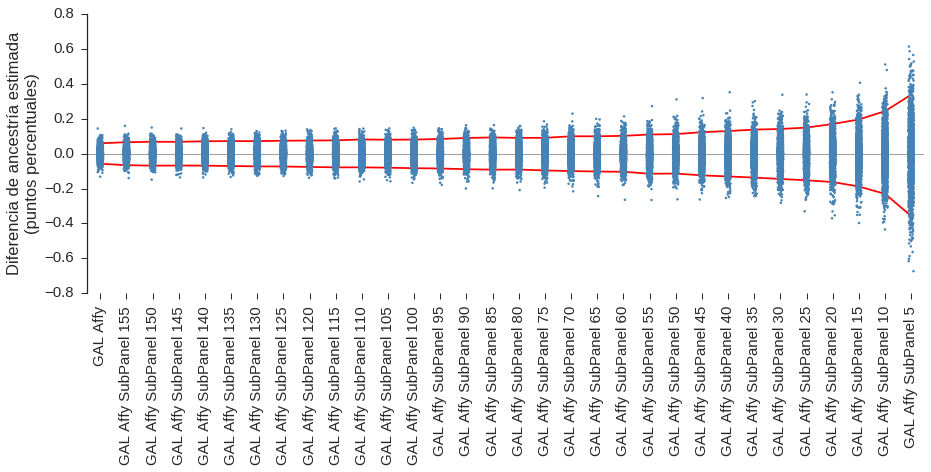

Diferencia en la estimación de ancestrías para cada subpanel con respecto a GAL_Completo. Cada punto es una ancestría estimada (AMR, EUR o AFR) en una muestra determinada. Se observa que la media transcurre alrededor del 0, pero el desvío estándar es alto, y el error de estimación para los límites de +-0.025 que definimos en todos los paneles (líneas rojas).
/home/juan/tesina/charts/ADMIXTURE/ancestry_differences_stripplot


In [58]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.set_context('notebook', font_scale=1.15)
sns.set_style('ticks')

sns.stripplot(ax=ax, x='panel', y='ancestry_diff', marker='.',
              data=tidy_diff, jitter=True, split=False, color='steelblue') #, palette='Set2')

for q in [0.025, 0.975]:
    quantiles = by_panel.quantile(q=q)[all_gal_panels()[1:]]
    quantiles.plot(ax=ax, color='red')

ax.axhline(0, linestyle='solid', color='gray', linewidth=0.75)
# ax.axhline(0.05, linestyle='dotted', color='red', linewidth=0.75)
# ax.axhline(-0.05, linestyle='dotted', color='red', linewidth=0.75)
# ax.axhline(0.1, linestyle='solid', color='red', linewidth=0.75)
# ax.axhline(-0.1, linestyle='solid', color='red', linewidth=0.75)
ax.set_xticklabels([l.get_text().replace('_', ' ') for l in ax.get_xticklabels()],
                    rotation=90)
ax.set_ylabel('Diferencia de ancestría estimada\n(puntos percentuales)')
ax.set_xlabel('')
ax.set_xlim([-0.5, len(tidy_diff.panel.unique()) - 0.5])

sns.despine(left=False, bottom=True)
filename = '/home/juan/tesina/charts/ADMIXTURE/ancestry_differences_stripplot'
plt.savefig(filename, bbox_inches='tight', dpi=300)

plt.show()
print('Diferencia en la estimación de ancestrías para cada subpanel con respecto a GAL_Completo. '
      'Cada punto es una ancestría estimada (AMR, EUR o AFR) en una muestra determinada. '
      'Se observa que la media transcurre alrededor del 0, pero el desvío estándar es alto, '
      'y el error de estimación para los límites de +-0.025 que definimos en todos los paneles '
      '(líneas rojas).')
print(filename)

 # Plot the p-values of the $t$-test: test which ancestries in each panel have a mean difference != 0, so they miss-estimate that ancestry

In [38]:
def ttest_zero_mean_pvalue(series):
    return ttest_1samp(series, 0).pvalue

panel
GAL_Affy                 0.999998
GAL_Affy_SubPanel_155    0.999999
GAL_Affy_SubPanel_150    0.999999
GAL_Affy_SubPanel_145    1.000000
GAL_Affy_SubPanel_140    0.999996
GAL_Affy_SubPanel_135    0.999989
GAL_Affy_SubPanel_130    0.999992
GAL_Affy_SubPanel_125    1.000000
GAL_Affy_SubPanel_120    0.999998
GAL_Affy_SubPanel_115    0.999996
GAL_Affy_SubPanel_110    0.999998
GAL_Affy_SubPanel_105    0.999994
GAL_Affy_SubPanel_100    0.999993
GAL_Affy_SubPanel_95     0.999998
GAL_Affy_SubPanel_90     0.999993
GAL_Affy_SubPanel_85     0.999995
GAL_Affy_SubPanel_80     0.999998
GAL_Affy_SubPanel_75     0.999998
GAL_Affy_SubPanel_70     0.999997
GAL_Affy_SubPanel_65     0.999996
GAL_Affy_SubPanel_60     0.999998
GAL_Affy_SubPanel_55     0.999998
GAL_Affy_SubPanel_50     0.999998
GAL_Affy_SubPanel_45     0.999995
GAL_Affy_SubPanel_40     0.999999
GAL_Affy_SubPanel_35     0.999999
GAL_Affy_SubPanel_30     0.999998
GAL_Affy_SubPanel_25     0.999995
GAL_Affy_SubPanel_20     0.999998
GAL_Affy

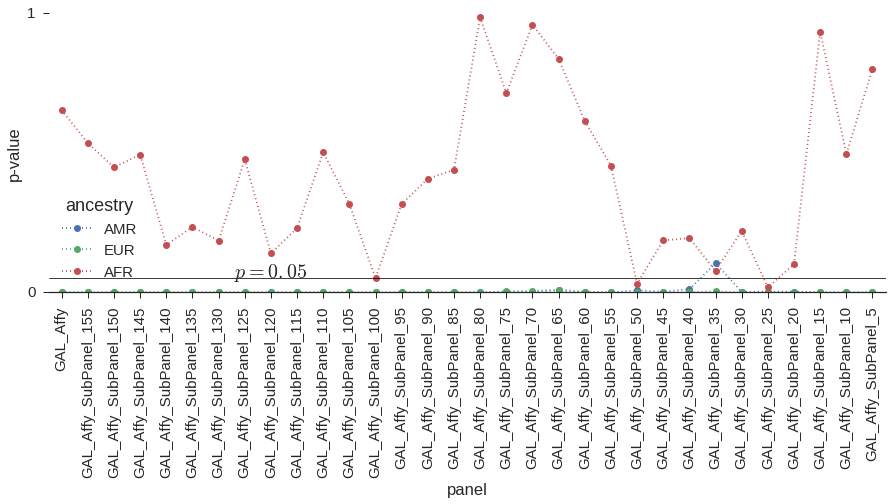

In [59]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(15, 5))
ttest_results.unstack('ancestry').plot(ax=ax, rot=90, linestyle='dotted', marker='o')

sns.despine(bottom=False, left=True)
ax.set_xticks(np.arange(len(panel_labels)))
ax.set_xticklabels(panel_labels)
ax.axhline(0.05, linestyle='solid', linewidth=0.75, color='black')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_ylabel('p-value')
ax.set_xlim([-0.5, len(panel_labels) - 0.5])
ax.text(8, 0.055, '$p = 0.05$', fontsize=20, horizontalalignment='center')
plt.show()

In [72]:
std_diffs.index = [l.split('.')[-1] for l in std_diffs.index]

In [73]:
summed_diffs
std_diffs

,AFR,AMR,EUR
GAL_Affy,0.021585,0.030220,0.030705
GAL_Affy_SubPanel_155,0.027850,0.032120,0.033487
GAL_Affy_SubPanel_150,0.028810,0.032974,0.034193
GAL_Affy_SubPanel_145,0.029265,0.033379,0.034350
GAL_Affy_SubPanel_140,0.030381,0.034190,0.035462
GAL_Affy_SubPanel_135,0.031712,0.034515,0.036400
GAL_Affy_SubPanel_130,0.031975,0.034964,0.036656
GAL_Affy_SubPanel_125,0.032547,0.034935,0.037668
GAL_Affy_SubPanel_120,0.033743,0.036024,0.038540
GAL_Affy_SubPanel_115,0.034074,0.037367,0.039740
